# Homologous recombination

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import subprocess
from tqdm import tqdm
import os
import subprocess
from pathlib import Path
import re

IS_SERVER = 1
if IS_SERVER:
    REGEX_PATH = Path("/storage/group/izg5139/default/nicole/MirrorRTR/chm13v2_regex_motifs.txt")
    G4_PATH = Path("/storage/group/izg5139/default/nicole/MirrorRTR/g4_results/chm13v2_g4hunter.txt")
    MIRROR_PATH = Path("/storage/group/izg5139/default/nicole/transfer_mirror/mirrors/chm13v2.0_MR.processed.tsv")
    CENTROMERE_PATH = Path("/storage/group/izg5139/default/nicole/transfer_mirror/primates/centromeres/chm13v2.0_censat_v2.0.bed")
    TELOMERE_PATH = Path("/storage/group/izg5139/default/nicole/transfer_mirror/primates/telomeres/chm13v2.0_telomere.bed")
    GFF_PATH = Path("/storage/group/izg5139/default/nicole/datasets/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz")
    GENOME_PATH = Path("/storage/group/izg5139/default/nicole/g4_RTR/genome.txt")
    PROMOTERS_PATH = Path("/storage/group/izg5139/default/nicole/datasets/promoters.expanded.bed.gz")
else:
    REGEX_PATH = Path("chm13v2_regex_motifs.txt")
    G4_PATH = Path("chm13v2_g4hunter.txt")
    CENTROMERE_PATH = Path("datasets/chm13v2.0_censat_v2.1.bed")
    TELOMERE_PATH = Path("datasets/chm13v2.0_telomere.bed")
    CYTOBAND_PATH = Path("datasets/chm13v2.0_cytobands_allchrs.bed")
    GENOME_PATH = Path("genome.txt")
    GFF_PATH = Path("datasets/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz")
    PROMOTERS_PATH = Path("datasets/promoters.expanded.bed")

%load_ext autoreload
%autoreload 2

In [3]:
import pybedtools
from pybedtools import BedTool
from pybedtools.featurefuncs import TSS

In [4]:
mirror_df = pd.read_table(MIRROR_PATH)
mirror_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition
0,chr1,1710,1752,accccaaccccaaccccaacc,.,accccaaccccaaccccaaccccaaccccaaccccaacccca,21,0,42,7,0,14,0,7A/14C/0G/0T
1,chr1,1712,1756,cccaaccccaaccccaacccca,.,cccaaccccaaccccaaccccaaccccaaccccaaccccaaccc,22,0,44,7,0,15,0,7A/15C/0G/0T
2,chr1,6739,6764,acaaaaataa,aagcc,acaaaaataaaagccaataaaaaca,10,5,25,8,0,1,1,8A/1C/0G/1T
3,chr1,17295,17316,aaaataaata,a,aaaataaataaataaataaaa,10,1,21,8,0,0,2,8A/0C/0G/2T
4,chr1,17607,17628,aaaaaacaaa,c,aaaaaacaaacaaacaaaaaa,10,1,21,9,0,1,0,9A/1C/0G/0T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256987,chrY,62453725,62453769,ttggggttggggttggggttgg,.,ttggggttggggttggggttggggttggggttggggttggggtt,22,0,44,0,14,0,8,0A/0C/14G/8T
1256988,chrY,62453777,62453814,gggtgggggtgggggtgg,g,gggtgggggtgggggtgggggtgggggtgggggtggg,18,1,37,0,15,0,3,0A/0C/15G/3T
1256989,chrY,62453779,62453818,gtgggggtgggggtggggg,t,gtgggggtgggggtgggggtgggggtgggggtgggggtg,19,1,39,0,16,0,3,0A/0C/16G/3T
1256990,chrY,62453862,62453919,gggttggggttggggttggggttgggg,tta,gggttggggttggggttggggttggggttaggggttggggttgggg...,27,3,57,0,19,0,8,0A/0C/19G/8T


In [5]:
def get_hdna_table(mirror_table):
    mirror_table.loc[:, "at"] = mirror_table["sequence"].str.count("a|t").div(mirror_table["sequenceLength"])
    mirror_table.loc[:, "ag"] = mirror_table["sequence"].str.count("a|g").div(mirror_table["sequenceLength"])
    mirror_table.loc[:, "ct"] = mirror_table["sequence"].str.count("c|t").div(mirror_table["sequenceLength"])
    hdna_df = mirror_table[(mirror_table["at"] < 0.8) & ((mirror_table["ag"] >= 0.9) | (mirror_table["ct"] >= 0.9))]
    return hdna_df
    
hdna_df = get_hdna_table(mirror_df)
hdna_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,at,ag,ct
10,chr1,50042,50071,ggagggaggga,ggcagaa,ggagggagggaggcagaaagggagggagg,11,7,29,3,8,0,0,3A/0C/8G/0T,0.310345,0.965517,0.034483
11,chr1,50059,50086,aagggaggga,ggcagaa,aagggagggaggcagaaagggagggaa,10,7,27,4,6,0,0,4A/0C/6G/0T,0.407407,0.962963,0.037037
12,chr1,50082,50111,ggaaggaagga,gcaagga,ggaaggaaggagcaaggaaggaaggaagg,11,7,29,5,6,0,0,5A/0C/6G/0T,0.448276,0.965517,0.034483
13,chr1,50095,50117,aaggaaggaag,.,aaggaaggaaggaaggaaggaa,11,0,22,6,5,0,0,6A/0C/5G/0T,0.545455,1.000000,0.000000
14,chr1,50097,50119,ggaaggaagga,.,ggaaggaaggaaggaaggaagg,11,0,22,5,6,0,0,5A/0C/6G/0T,0.454545,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256887,chrY,62192837,62192864,ctctctctctctc,t,ctctctctctctctctctctctctctc,13,1,27,0,0,7,6,0A/7C/0G/6T,0.481481,0.000000,1.000000
1256900,chrY,62247108,62247130,aaagaaggaag,.,aaagaaggaaggaaggaagaaa,11,0,22,7,4,0,0,7A/0C/4G/0T,0.636364,1.000000,0.000000
1256901,chrY,62247260,62247284,gggagggagg,ggat,gggagggaggggatggagggaggg,10,4,24,2,8,0,0,2A/0C/8G/0T,0.250000,0.958333,0.041667
1256903,chrY,62255805,62255833,aggaggaggaggag,.,aggaggaggaggaggaggaggaggagga,14,0,28,5,9,0,0,5A/0C/9G/0T,0.357143,1.000000,0.000000


In [6]:
hdna_df.spacerLength.max()

7

In [7]:
chipseq_rep1 = pd.read_table(
                       "/storage/group/izg5139/default/transfer_PRMD9/withReps2/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                       #"/scratch/nmc6088/prdm9/withRepsNikolNoBlacklist/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                       # "/scratch/nmc6088/prdm9/withRepsNikolBlacklistNorDNA_V4/bowtie2/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                       header=None,
                       usecols=range(3),
                       names=["seqID", "start", "end"] #, "score"]
                    )
chipseq_rep1_bed = BedTool.from_dataframe(chipseq_rep1).sort().merge()
chipseq_rep2 = pd.read_table(
                        "/storage/group/izg5139/default/transfer_PRMD9/withReps2/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                        # "/scratch/nmc6088/prdm9/withRepsNikolNoBlacklist/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                        # "/scratch/nmc6088/prdm9/withRepsNikolBlacklistNorDNA_V4/bowtie2/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                       header=None,
                       usecols=range(3),
                       names=["seqID", "start", "end"] #, "score"]
                    )
chipseq_rep2_bed = BedTool.from_dataframe(chipseq_rep2).sort().merge()

In [8]:
CENTROMERIC_REGIONS = {
                       "hor": "Higher Order Repeats",
                       "dhor": "Inactive?",
                       "mon": "Monomeric",
                       "hsat1A": "Classical Human Satellite 1A",
                       "hsat1B": "Classical Human Satellite 1B",
                       "hsat2": "Classical Human Satellite 2",
                       "hsat3": "Classical Human Satellite 3",
                       "bsat": "Beta Satellite",
                       "gsat": "Gamma Satellite",
                       "censat": "Other centromeric satellites",
                       "ct": "Centromeric transition regions"
                      }
telomere_df = pd.read_table(TELOMERE_PATH, header=None, names=["seqID", "start", "end"])
telomere_df.loc[:, "compartment"] = "Telomere"

CENTROMERE_PATH = Path("/storage/group/izg5139/default/nicole/transfer_mirror/primates/centromeres/chm13v2.0_censat_v2.0.bed")
centromere_chm = pd.read_table(CENTROMERE_PATH, skiprows=1, header=None, usecols=range(4), names=["seqID", "start", "end", "compartment"])
centromere_chm.loc[:, "compartment"] = centromere_chm["compartment"].apply(lambda x: x.split("_")[0])
centromere_chm = pd.concat([centromere_chm, telomere_df])
unique_compartments = centromere_chm['compartment'].unique()

merged_centromeric_compartments = []
for compartment in tqdm(unique_compartments):
    centro_bed = (
                    BedTool.from_dataframe(centromere_chm[centromere_chm['compartment'] == compartment])
                    .sort()
                    .merge()
                )
    temp_centro = pd.read_table(
                    centro_bed.fn,
                    header=None,
                    names=["seqID", "start", "end"]
    )
    temp_centro.loc[:, "compartment"] = compartment
    merged_centromeric_compartments.append(temp_centro)
    
merged_centromeric_compartments = pd.concat(merged_centromeric_compartments, axis=0)
merged_centromeric_compartments_bed = BedTool.from_dataframe(merged_centromeric_compartments)
merged_centromeric_compartments

100%|██████████| 13/13 [00:00<00:00, 115.76it/s]


,seqID,start,end,compartment
0,chr1,116796047,121405145,ct
1,chr1,121406286,121619169,ct
2,chr1,121788213,121790362,ct
3,chr1,126838321,126840458,ct
4,chr1,126848989,126877724,ct
...,...,...,...,...
45,chr9,150614400,150617247,Telomere
46,chrX,0,2000,Telomere
47,chrX,154256800,154259566,Telomere
48,chrY,0,5800,Telomere


In [15]:
!cp /storage/home/nmc6088/SupplementaryFile7.chm13v2.PRDM9.tsv\?download\=1 .

In [16]:
recombination_data = pd.read_table("SupplementaryFile7.chm13v2.PRDM9.tsv?download=1")
recombination_data.loc[:, "chromosome"] = recombination_data["sequence_name"].str.split("#", expand=True)[1]
recombination_data.dropna(subset=['sequence_name'], inplace=True)
recombination_data.dropna(subset=['start'], inplace=True)
recombination_data['start'] = recombination_data['start'].astype(int) - 1
recombination_data["stop"] = recombination_data["stop"].astype(int)
recombination_data

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,chromosome
0,Human17,NaN,chm13#chr5,158531244,158531318,-,40.9024,1.250000e-29,3.120000e-21,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,chr5
1,Human17,NaN,chm13#chr5,158531245,158531319,-,40.9024,1.250000e-29,3.120000e-21,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,chr5
2,Human17,NaN,chm13#chr5,158531246,158531320,-,40.9024,1.250000e-29,3.120000e-21,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,chr5
3,Human17,NaN,chm13#chr5,158531247,158531321,-,40.9024,1.250000e-29,3.120000e-21,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,chr5
4,Human17,NaN,chm13#chr4,169960615,169960689,-,40.9024,1.250000e-29,3.120000e-21,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,chr4
...,...,...,...,...,...,...,...,...,...,...,...
1216996,Human10,NaN,chm13#chr1,245254165,245254175,-,13.8374,1.190000e-05,8.260000e-01,GTGACTCAGT,chr1
1216997,Human10,NaN,chm13#chr1,246222567,246222577,+,13.8374,1.190000e-05,8.260000e-01,GTGACTCAGT,chr1
1216998,Human10,NaN,chm13#chr1,246293918,246293928,-,13.8374,1.190000e-05,8.260000e-01,GTGACTCAGT,chr1
1216999,Human10,NaN,chm13#chr1,246842832,246842842,+,13.8374,1.190000e-05,8.260000e-01,GTGACTCAGT,chr1


In [17]:
recombination_data_bed = BedTool.from_dataframe(recombination_data[["chromosome", "start", "stop"]]).sort()

In [18]:
recombination_data_bed.intersect(chip_df_bed, u=True).count(), recombination_data_bed.count(), chip_df_bed.count()

(138818, 1217001, 62003)

In [19]:
hdna_df_bed = BedTool.from_dataframe(hdna_df).sort().merge()
hdna_df_bed.count()

123604

In [20]:
recombination_data_bed_with_hdna = recombination_data_bed.intersect(hdna_df_bed, u=True)\
                                                         .intersect(chip_df_bed, u=True)

In [21]:
hdna_df_bed.intersect(chip_df_bed, u=True).count()

5953

In [22]:
chip_df_bed.intersect(hdna_df_bed, u=True).count()

3129

In [23]:
recombination_data_bed_with_hdna.count()

20661

In [24]:
from mindi.coverage.pwm_density import PWMExtractor
from pybedtools.featurefuncs import midpoint, TSS

WINDOW = 5_000
extractor = PWMExtractor()

# Density ChipSeq Rep

In [25]:
chipseq_rep1 = pd.read_table(
                       "/storage/group/izg5139/default/transfer_PRMD9/withReps2/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                       # "/scratch/nmc6088/prdm9/withRepsNikolBlacklistNorDNA_V4/bowtie2/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                        # "/scratch/nmc6088/prdm9/withRepsNikolNoBlacklist/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",

                       header=None,
                       usecols=range(3),
                       names=["seqID", "start", "end"] #, "score"]
                    )
chipseq_rep1_bed = BedTool.from_dataframe(chipseq_rep1).sort().merge()
chipseq_rep2 = pd.read_table(
                        "/storage/group/izg5139/default/transfer_PRMD9/withReps2/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                       #  "/scratch/nmc6088/prdm9/withRepsNikolNoBlacklist/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                        # "/scratch/nmc6088/prdm9/withRepsNikolBlacklistNorDNA_V4/bowtie2/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                        header=None,
                        usecols=range(3),
                        names=["seqID", "start", "end"] #, "score"]
                    )
chipseq_rep2_bed = BedTool.from_dataframe(chipseq_rep2).sort().merge()

chip_df = pd.read_table(
                        chipseq_rep1_bed.intersect(chipseq_rep2_bed, 
                                                   f=0.2, 
                                                   r=True)
                                        .sort()
                                        .merge()
                                        .fn,
                        header=None,
                        names=["seqID", "start", "end"] #, "chromosome", "second_start", "second_end", "overlap"]
)
# chip_df["union_start"] = np.minimum(chip_df["start"], chip_df["second_start"])
# chip_df["union_end"] = np.maximum(chip_df["end"], chip_df["second_end"])
# chip_df = chip_df[["seqID", "union_start", "union_end"]].rename(columns={"union_start": "start", 
                                                                         # "union_end": "end"})
chip_df_bed = BedTool.from_dataframe(chip_df).sort()
chip_df

,seqID,start,end
0,chr1,318378,318764
1,chr1,331445,331821
2,chr1,334477,334888
3,chr1,340821,341322
4,chr1,353254,355381
...,...,...,...
61998,chrX,153501619,153501947
61999,chrX,153548994,153549243
62000,chrX,153875745,153876157
62001,chrY,1329834,1330890


In [26]:
hdna_df_bed = BedTool.from_dataframe(hdna_df)
chip_df_bed.intersect(hdna_df_bed, u=True).count()

3129

In [27]:
hdna_df_bed = BedTool.from_dataframe(hdna_df)
chip_df_bed.intersect(hdna_df_bed, u=True).count()

3129

In [28]:
3129 * 1e2 / 62003

5.046530006612583

In [ ]:
recombination_coverage = pd.read_table(
                        merged_centromeric_compartments_bed.coverage(recombination_data_bed).fn,
                        header=None,
                        names=["seqID", "start", "end", "compartment", "totalHits", "overlappingBp", "compartmentLength", "coverage"]
)
recombination_coverage['coverage'] = 1e2 * recombination_coverage['coverage']

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(
            data=recombination_coverage,
            x="compartment",
            y="coverage",
            ax=ax,
            zorder=3,
            capsize=.2,
            color='gray',
            errorbar=('ci', 99),
            order=recombination_coverage.groupby("compartment")\
                        .agg({"coverage": "mean"})\
                        .sort_values(by=['coverage'], ascending=False).index.tolist()
            )
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=14)
ax.tick_params(axis="x", labelsize=16, rotation=60)
ax.set_ylabel("PRMD9 Motif Coverage (%)")
ax.set_xlabel('')
ax.yaxis.label.set_size(16)
fig.savefig("/storage/group/izg5139/default/nicole/MirrorRTR/figures_hdna_rtr/prmd9_motif_binding_coverage_satellites.png", bbox_inches='tight')

In [ ]:
rDNA = merged_centromeric_compartments.query("compartment == 'rDNA'")
rDNA

## Chip Seq Peaks within rDNA

In [ ]:
chip_df_rDNA = chip_df.merge(rDNA, 
                             on="seqID", 
                             how="inner", 
                             suffixes=("", "_rDNA")
                            )
chip_df_rDNA["is_rDNA"] = (((chip_df_rDNA["end_rDNA"] >= chip_df_rDNA["start"]) & (chip_df_rDNA["start"] >= chip_df_rDNA["start_rDNA"])) |
                           (((chip_df_rDNA["start_rDNA"] <= chip_df_rDNA["end"]) & (chip_df_rDNA["end"] <= chip_df_rDNA["end_rDNA"])))
                          ).astype(int)
chip_df_rDNA = chip_df_rDNA[chip_df_rDNA['is_rDNA'] == 1]
chip_df_rDNA.is_rDNA.value_counts()

In [ ]:
from pybedtools.featurefuncs import midpoint
from mindi.coverage.pwm_density import PWMExtractor
extractor = PWMExtractor()

chip_df = pd.read_table(
                        chipseq_rep1_bed.intersect(chipseq_rep2_bed, 
                                                   f=0.2, 
                                                   r=True)
                                        .sort()
                                        .merge()
                                        .fn,
                        header=None,
                        names=["seqID", "start", "end"] #, "chromosome", "second_start", "second_end", "overlap"]
)
# chip_df["union_start"] = np.minimum(chip_df["start"], chip_df["second_start"])
# chip_df["union_end"] = np.maximum(chip_df["end"], chip_df["second_end"])
# chip_df = chip_df[["seqID", "union_start", "union_end"]].rename(columns={"union_start": "start", 
                                                                         # "union_end": "end"})
WINDOW = 1_000
chip_df_bed = BedTool.from_dataframe(chip_df).sort()
print(chip_df_bed.count())

def extract_midpoints(df: pd.DataFrame, 
                      window_size: int = 2_000):
    df_bed = BedTool.from_dataframe(df)
    features = [{"seqID": feature.chrom,
                 "start": feature.start,
                 "end": feature.end,
                "strand": "+"
                } for feature in df_bed.each(midpoint)\
                                       .slop(g="/storage/group/izg5139/default/nicole/datasets/genome.txt",
                                             l=window_size,
                                             r=window_size
                                            )]
    features = pd.DataFrame(features)
    return features
    
chip_df_mid = extract_midpoints(chip_df, window_size=WINDOW)
chip_df_mid_bed = BedTool.from_dataframe(chip_df_mid).sort()

intersect_df = pd.read_table(
                    chip_df_mid_bed.intersect(hdna_df_bed.sort().merge(), wo=True).fn,
                    header=None,
                    names=["seqID", "start", "end", "strand", "chrom", "motif_start", "motif_end", "overlap"]
)
density = np.array(extractor.extract_density(intersect_df, window_size=WINDOW))
density = density / np.mean(density)

In [43]:
chip_df_mid_bed.intersect(hdna_df_bed, u=True).count()

5481

In [42]:
chip_df = pd.read_table(
                        chipseq_rep1_bed.intersect(chipseq_rep2_bed, 
                                                   f=0.2, 
                                                   r=True)
                                        .sort()
                                        .merge()
                                        .fn,
                        header=None,
                        names=["seqID", "start", "end"] #, "chromosome", "second_start", "second_end", "overlap"]
)
# chip_df["union_start"] = np.minimum(chip_df["start"], chip_df["second_start"])
# chip_df["union_end"] = np.maximum(chip_df["end"], chip_df["second_end"])
# chip_df = chip_df[["seqID", "union_start", "union_end"]].rename(columns={"union_start": "start", 
                                                                         # "union_end": "end"})
chip_df_bed = BedTool.from_dataframe(chip_df).sort()
print(chip_df_bed.count())

def extract_midpoints(df: pd.DataFrame, 
                      window_size: int = 2_000):
    df_bed = BedTool.from_dataframe(df)
    features = [{"seqID": feature.chrom,
                 "start": feature.start,
                 "end": feature.end,
                "strand": "+"
                } for feature in df_bed.each(midpoint)\
                                       .slop(g="/storage/group/izg5139/default/nicole/datasets/genome.txt",
                                             l=window_size,
                                             r=window_size
                                            )]
    features = pd.DataFrame(features)
    return features
    
chip_df_mid = maker.make_windows(chip_df, 
                                 loci="mid", 
                                 genome="/storage/group/izg5139/default/nicole/datasets/genome.txt").drop(columns=['chromosomeSize'])
chip_df_mid["strand"] = "+"
chip_df_mid_bed = BedTool.from_dataframe(chip_df_mid).sort()

intersect_df = pd.read_table(
                    chip_df_mid_bed.intersect(hdna_df_bed.sort().merge(), wo=True).fn,
                    header=None,
                    names=["seqID", "start", "end", "strand", "chrom", "motif_start", "motif_end", "overlap"]
)
density = np.array(extractor.extract_density(intersect_df, window_size=WINDOW))
density = density / np.mean(density)

62003


In [46]:
chip_enrichment = np.max(density)
chip_enrichment

2.636010223962507

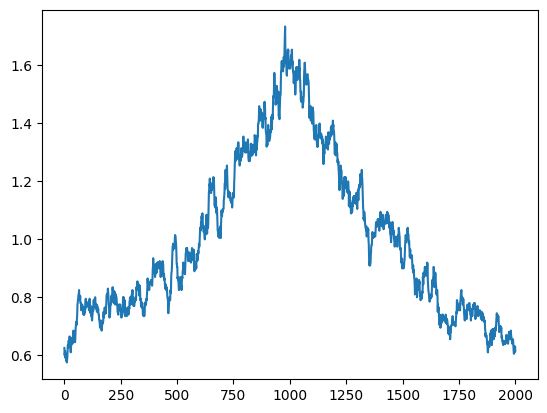

In [44]:
plt.plot(density)

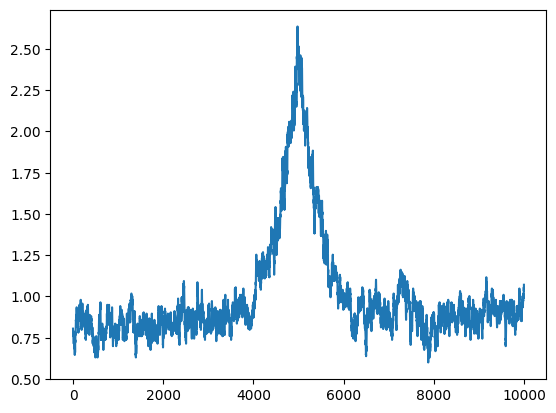

In [43]:
plt.plot(density)

In [44]:
chip_df_mid_bed.intersect(hdna_df_bed, u=True).count()

17194

In [ ]:
chip_df_mid_bed.intersect(recombination_data_bed, u=True).count()

In [ ]:
hdna_df_bed2 = BedTool.from_dataframe(hdna_df[["seqID", "start", "end"]]).sort()
hdna_df_bed2.fn

In [ ]:
extractor = PWMExtractor()
extractor

In [583]:
relative_df = extractor.get_relative_positions(intersect_df, 
                                               window_size=WINDOW)
relative_df

,-5000,-4999,-4998,-4997,-4996,-4995,-4994,-4993,-4992,-4991,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
def bootstrap(intersect_df, samples = 1_000):
    total = intersect_df.shape[0]
    bootstrap = []
    for _ in tqdm(range(samples), leave=True, position=0):
        density = list(intersect_df.sample(total, replace=True).sum())
        bootstrap.append(density)
    bootstrap = pd.DataFrame(bootstrap)
    return bootstrap

# bootstrap_df = bootstrap(relative_df, samples=1_000)
# bootstrap_df

In [589]:
bootstrap_enrichment = bootstrap_df.apply(lambda row: row / np.mean(row), axis=1)
bootstrap_enrichment

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,0.952419,0.914322,0.899083,0.891464,0.891464,0.876225,0.830509,0.838129,0.822890,0.860987,...,0.830509,0.815271,0.807651,0.830509,0.800032,0.845748,0.845748,0.891464,0.891464,0.929561
1,0.878136,0.885772,0.870500,0.839956,0.839956,0.862864,0.832320,0.832320,0.809412,0.832320,...,0.962132,0.962132,0.969768,0.939224,0.923952,0.969768,0.977404,1.023219,1.007947,1.046127
2,0.707456,0.677028,0.692242,0.669421,0.669421,0.684635,0.669421,0.707456,0.707456,0.737884,...,1.026952,1.004131,1.019345,1.019345,1.011738,1.057380,1.034559,1.049773,1.011738,1.072594
3,0.779938,0.764793,0.787510,0.779938,0.779938,0.764793,0.734505,0.726932,0.696644,0.719360,...,1.014677,1.007104,1.037393,1.037393,1.029821,1.052538,1.067682,1.105543,1.067682,1.120687
4,0.902442,0.849357,0.834190,0.819023,0.819023,0.834190,0.796272,0.811440,0.819023,0.864524,...,0.970694,0.963110,0.985861,0.963110,1.008612,1.023779,0.993445,1.016195,1.023779,1.114781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.769544,0.731822,0.731822,0.716733,0.716733,0.724277,0.709188,0.739366,0.739366,0.746911,...,1.048693,1.033604,1.041148,1.041148,1.056238,1.078871,1.071327,1.116594,1.078871,1.109049
996,0.856094,0.794944,0.772013,0.772013,0.772013,0.741438,0.710863,0.710863,0.726151,0.749082,...,1.123623,1.108335,1.138910,1.115979,1.131267,1.154198,1.146554,1.169485,1.161841,1.192416
997,0.836538,0.790909,0.790909,0.806119,0.806119,0.790909,0.783304,0.836538,0.836538,0.859353,...,0.882168,0.882168,0.882168,0.874563,0.935402,0.996241,0.973427,0.988636,0.981031,1.019056
998,0.769475,0.746843,0.739299,0.739299,0.739299,0.754387,0.754387,0.769475,0.746843,0.716668,...,1.124037,1.131581,1.139124,1.101405,1.116493,1.154212,1.101405,1.146668,1.124037,1.161756


In [592]:
lower_q = bootstrap_enrichment.quantile(0.025, axis=0)
upper_q = bootstrap_enrichment.quantile(0.975, axis=0)

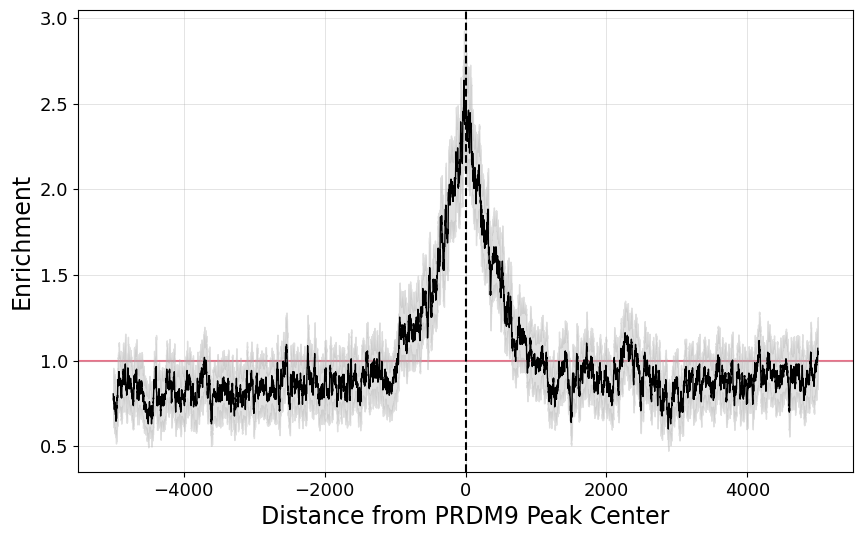

In [594]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
window_size = WINDOW
ax.plot(
        range(-window_size, window_size+1), 
        density, 
        color="black",
        alpha=1.0,
        lw=1.0)
ax.axvline(0.0, linestyle='--', label='PRMD9', color='black')
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.axhline(1.0, 
           linestyle='-', 
           color='crimson', 
           alpha=0.6, 
           zorder=0)
ax.fill_between(
                x=range(-window_size, window_size+1), 
                y1=lower_q,
                y2=upper_q,
                color=sns.color_palette("Set2")[7],
                alpha=0.4,
                zorder=0
               )
ax.tick_params(axis="both", labelsize=13)
ax.set_xlabel("Distance from PRDM9 Peak Center")
ax.xaxis.label.set_size(17)
ax.set_ylabel("Enrichment")
ax.yaxis.label.set_size(17)
fig.savefig("/storage/group/izg5139/default/nicole/MirrorRTR/figures_hdna_rtr/chipseq_HDNA_density_plot_5kb_N=1000.png", bbox_inches='tight')

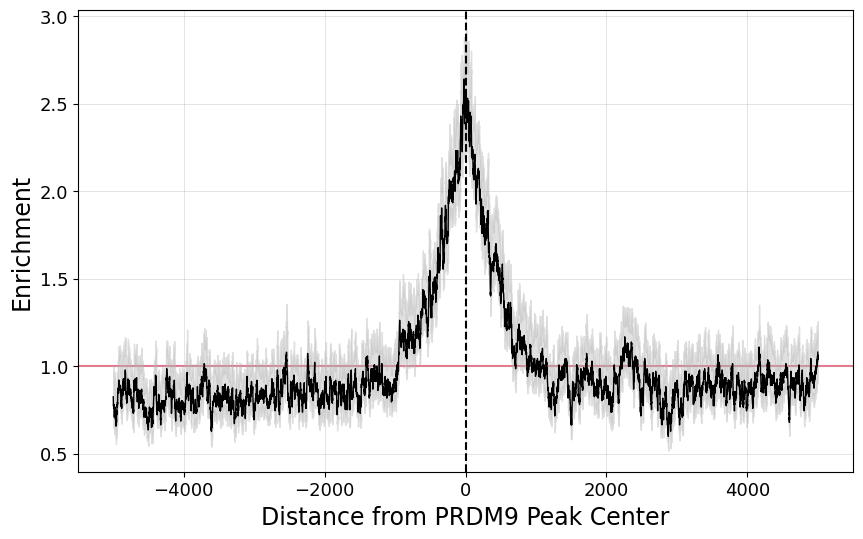

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
window_size = WINDOW
ax.plot(
        range(-window_size, window_size+1), 
        density, 
        color="black",
        alpha=1.0,
        lw=1.0)
ax.axvline(0.0, linestyle='--', label='PRMD9', color='black')
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.axhline(1.0, 
           linestyle='-', 
           color='crimson', 
           alpha=0.6, 
           zorder=0)
ax.fill_between(
                x=range(-window_size, window_size+1), 
                y1=lower_q,
                y2=upper_q,
                color=sns.color_palette("Set2")[7],
                alpha=0.4,
                zorder=0
               )
ax.tick_params(axis="both", labelsize=13)
ax.set_xlabel("Distance from PRDM9 Peak Center")
ax.xaxis.label.set_size(17)
ax.set_ylabel("Enrichment")
ax.yaxis.label.set_size(17)
fig.savefig("/storage/group/izg5139/default/nicole/MirrorRTR/figures_hdna_rtr/chipseq_HDNA_density_plot_5kb.png", bbox_inches='tight')

### PRMD9 - Recombination Motif

In [55]:
WINDOW = 2_000
recombination_data_rDNA = recombination_data.rename(columns={"stop": "end"})\
                        .merge(rDNA, 
                             left_on="chromosome",
                             right_on="seqID", 
                             how="inner", 
                             suffixes=("", "_rDNA")
                            )
recombination_data_rDNA["is_rDNA"] = (((recombination_data_rDNA["end_rDNA"] >= recombination_data_rDNA["start"]) & (recombination_data_rDNA["start"] >= recombination_data_rDNA["start_rDNA"])) |
                           (((recombination_data_rDNA["start_rDNA"] <= recombination_data_rDNA["end"]) & (recombination_data_rDNA["end"] <= recombination_data_rDNA["end_rDNA"])))
                          ).astype(int)
recombination_data_rDNA = recombination_data_rDNA[recombination_data_rDNA['is_rDNA'] == 1]
recombination_data_rDNA.is_rDNA.value_counts()

is_rDNA
1    50266
Name: count, dtype: int64

In [56]:
hdna_df_bed = BedTool.from_dataframe(hdna_df).sort()
hdna_df_bed

<BedTool(/tmp/pybedtools.ig052kyc.tmp)>

In [60]:
def extract_midpoints(df: pd.DataFrame, window_size: int = 2_000):
    df_bed = BedTool.from_dataframe(df)
    features = [{"seqID": feature.chrom,
                 "start": feature.start,
                 "end": feature.end,
                "strand": "+"
                } for feature in df_bed.each(midpoint)\
                                 .slop(g="/storage/group/izg5139/default/nicole/datasets/genome.txt",
                                       l=window_size,
                                       r=window_size
                                      )
               ]
    features = pd.DataFrame(features)
    return features

recombination_data_temp = recombination_data[["chromosome", "start", "stop"]]
recombination_df_mid = extract_midpoints(recombination_data_temp, window_size=WINDOW)
recombination_df_mid_bed = BedTool.from_dataframe(recombination_df_mid).sort()

intersect_recombination_df = pd.read_table(
                    recombination_df_mid_bed.intersect(hdna_df_bed.sort().merge(), wo=True).fn,
                    header=None,
                    names=["seqID", "start", "end", "strand", "chrom", "motif_start", "motif_end", "overlap"]
)
density_recombination = np.array(extractor.extract_density(intersect_recombination_df, window_size=WINDOW))
density_recombination = density_recombination / np.mean(density_recombination)
density_recombination.shape

(4001,)

In [ ]:
relative_recombination_df = extractor.get_relative_positions(intersect_recombination_df, window_size=WINDOW)
relative_recombination_df

In [172]:
recombination_data_temp = recombination_data_rDNA[["chromosome", "start", "end"]]
recombination_df_mid = extract_midpoints(recombination_data_temp, window_size=WINDOW)
recombination_df_mid_bed = BedTool.from_dataframe(recombination_df_mid).sort()
intersect_recombination_rDNA = pd.read_table(
                    recombination_df_mid_bed.intersect(hdna_df_bed.sort().merge(), wo=True).fn,
                    header=None,
                    names=["seqID", "start", "end", "strand", "chrom", "motif_start", "motif_end", "overlap"]
)
density_recombination_rDNA = np.array(extractor.extract_density(intersect_recombination_rDNA, 
                                                                window_size=WINDOW))
density_recombination_rDNA = density_recombination_rDNA / np.mean(density_recombination_rDNA)
density_recombination_rDNA.shape

(10001,)

In [1]:
# bootstrap_recombination_df = bootstrap(intersect_recombination_df, samples=10)
# bootstrap_recombination_df

In [ ]:
lower_recombination_q = bootstrap_recombination_df.quantile(0.1, axis=0)
upper_recombination_q = bootstrap_recombination_df.quantile(0.99, axis=0)

In [61]:
np.max(density_recombination)

7.167418256195005

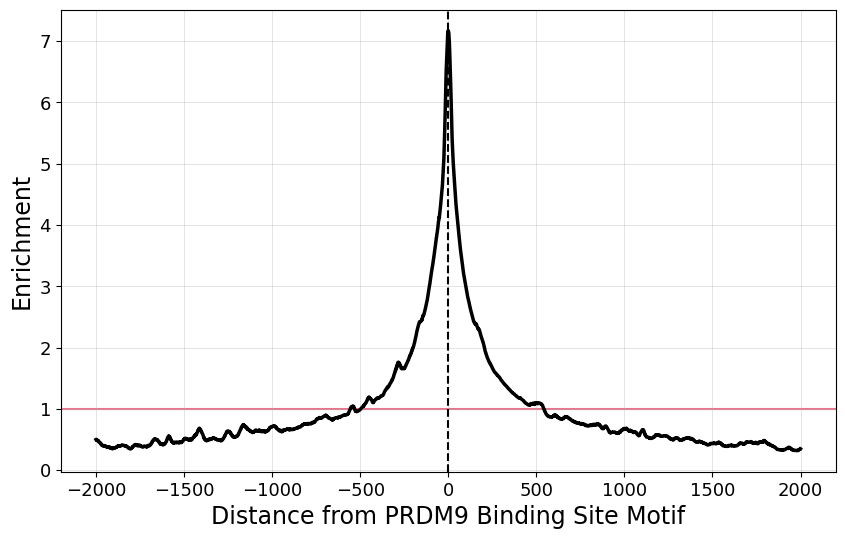

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
window_size = WINDOW
ax.plot(
        range(-window_size, window_size+1), 
        density_recombination, 
        color="black",
        alpha=1.0,
        lw=2.5)
ax.axvline(0.0, linestyle='--', label='PRMD9', color='black')
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.axhline(1.0, 
           linestyle='-', 
           color='crimson', 
           alpha=0.6, 
           zorder=0)
# ax.fill_between(
#                 x=range(-window_size, window_size+1), 
#                 y1=lower_recombination_q,
#                 y2=upper_recombination_q,
#                 color=sns.color_palette("Set2")[7],
#                 alpha=0.2,
#                 zorder=0
#                )
ax.tick_params(axis="both", labelsize=13)
ax.set_xlabel("Distance from PRDM9 Binding Site Motif")
ax.xaxis.label.set_size(17)
ax.set_ylabel("Enrichment")
ax.yaxis.label.set_size(17)
fig.savefig("/storage/group/izg5139/default/nicole/MirrorRTR/figures_hdna_rtr/recombination_motif_HDNA_density_plot_5kb.png", bbox_inches='tight')

In [122]:
help(extract_density)

Help on function extract_density in module mindi.coverage.density_plot:

extract_density(extraction: str, gff_file: str, window_size: int, density_type: str = 'density', determine_strand: Optional[Callable[[str], str]] = None) -> Iterator[mindi.coverage.density_plot.Density]



In [239]:
recombination_data['motif_id'].unique()

array(['Human17', 'Human14', 'Human4', 'Human12', 'Human13', 'Human16',
       'Human1', 'Human3', 'Human11', 'Human8', 'Human9', 'Human7',
       'Human6', 'Human5', 'Human2', 'Human15', 'Human10'], dtype=object)

In [240]:
df = pd.read_table(mirror_paths['chm13v2'])
df.loc[:, "sequenceLength"] = df["sequence"].apply(len)
df.loc[:, "pyrine"] = df["sequence"].str.count("a|g").div(df['sequenceLength'])
df.loc[:, "pyrimidine"] = df["sequence"].str.count("c|t").div(df['sequenceLength'])
df.loc[:, "at_content"] = df["sequence"].str.count("a|t").div(df['sequenceLength'])

df = df.query("armLength > 9 & spacerLength < 8")
df = df[((df['pyrine'] >= 0.9) | (df['pyrimidine'] >= 0.9)) & (df['at_content'] <= 0.8)]
df

,#assembly_accession,chromosome,sequenceLength,armLength,composition,start,end,sequenceOfArm,sequenceOfSpacer,spacerLength,sequence,arm_a,arm_c,arm_g,arm_t,pyrine,pyrimidine,at_content
72,chm13v2.0,chr1,29,11,3A/0C/8G/0T,50042,50071,ggagggaggga,ggcagaa,7,ggagggagggaggcagaaagggagggagg,3,0,8,0,0.965517,0.034483,0.310345
73,chm13v2.0,chr1,27,10,4A/0C/6G/0T,50059,50086,aagggaggga,ggcagaa,7,aagggagggaggcagaaagggagggaa,4,0,6,0,0.962963,0.037037,0.407407
106,chm13v2.0,chr1,39,19,15A/0C/4G/0T,73390,73429,agaaagaaaaagaaagaaa,g,1,agaaagaaaaagaaagaaagaaagaaagaaaaagaaaga,15,0,4,0,1.000000,0.000000,0.769231
108,chm13v2.0,chr1,43,21,16A/0C/5G/0T,73420,73463,aaagaaagaaagaaagaaaga,a,1,aaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaa,16,0,5,0,1.000000,0.000000,0.767442
109,chm13v2.0,chr1,43,21,16A/0C/5G/0T,73422,73465,agaaagaaagaaagaaagaaa,g,1,agaaagaaagaaagaaagaaagaaagaaagaaagaaagaaaga,16,0,5,0,1.000000,0.000000,0.744186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411965,chm13v2.0,chrY,27,13,0A/6C/0G/7T,62192836,62192863,tctctctctctct,c,1,tctctctctctctctctctctctctct,0,6,0,7,0.000000,1.000000,0.518519
4411966,chm13v2.0,chrY,27,13,0A/7C/0G/6T,62192837,62192864,ctctctctctctc,t,1,ctctctctctctctctctctctctctc,0,7,0,6,0.000000,1.000000,0.481481
4412014,chm13v2.0,chrY,22,11,7A/0C/4G/0T,62247108,62247130,aaagaaggaag,NaN,0,aaagaaggaaggaaggaagaaa,7,0,4,0,1.000000,0.000000,0.636364
4412032,chm13v2.0,chrY,28,14,5A/0C/9G/0T,62255805,62255833,aggaggaggaggag,NaN,0,aggaggaggaggaggaggaggaggagga,5,0,9,0,1.000000,0.000000,0.357143


<Axes: ylabel='Frequency'>

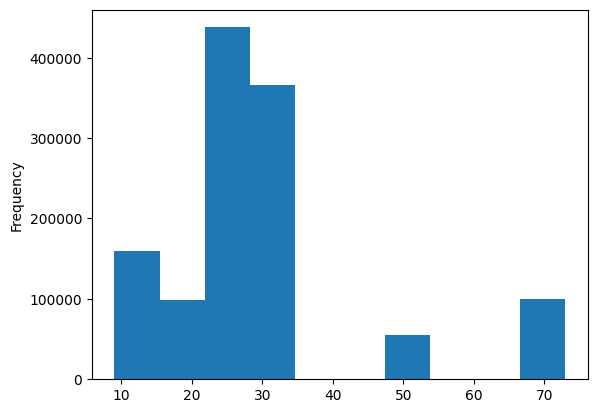

In [243]:
recombination_data.loc[:, "length"] = recombination_data["stop"] - recombination_data["start"]
recombination_data['length'].plot(kind="hist")

In [244]:
recombination_data.head(2)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,chromosome,length
0,Human17,NaN,chm13#chr5,158531245.0,158531318.0,-,40.9024,1.250000e-29,3.120000e-21,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,chr5,73.0
1,Human17,NaN,chm13#chr5,158531246.0,158531319.0,-,40.9024,1.250000e-29,3.120000e-21,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,chr5,73.0


In [245]:
recombination_data = recombination_data.astype({
                                                "start": int, 
                                                "stop": int
                                            })

In [246]:
recombination_data.shape

(1217001, 12)

In [247]:
recombination_path = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/recombination")
recombination_path.mkdir(exist_ok=True)

In [257]:
human_mirror = recombination_path.joinpath("mirror_human.bed")
recombination_bed = recombination_path.joinpath("recombination.bed")
coverage_out = recombination_path.joinpath("coverage_recombination.bed")

a = pybedtools.BedTool.from_dataframe(df[["chromosome", "start", "end", "sequence"]]).sort()
b = pybedtools.BedTool.from_dataframe(recombination_data[["chromosome", "start", "stop", "matched_sequence"]])\
                            .sort()\
                            .merge(
                                   c=["4", "4"], 
                                   o=["count", "collapse"]
                            )
    
# command = f"bedtools coverage -a {recombination_bed} -b {human_mirror} > {coverage_out}"
# subprocess.run(command, shell=True, check=True)

# coverage_df = pd.read_table(coverage_out, header=None,)
# coverage_df
b.head()

chr1	3545	3564	1	TCCCCTGCTGGCGCCGGGGC
 chr1	9488	9497	1	GTGACTCACC
 chr1	10627	10636	1	ATGAGTCAGC
 chr1	12786	12808	1	CCTTGCTGACCTCTGCTGCCACC
 chr1	14676	14707	1	TGGGGTCTCCTGTTTCCCTCCTCCTCCTCCCC
 chr1	14967	14997	1	GCAGCCTGGTTGGGGTGGGCACCCCGGCTAC
 chr1	15294	15317	1	GTCTTCCTGCCCCTGTCTCCACCA
 chr1	18586	18595	1	GTGACTCAGC
 chr1	19701	19731	1	GCTCTGCAGATTCTGAGGACCACCTCCCTTA
 chr1	30606	30615	1	CTGACTCAGC
 

In [258]:
b.to_dataframe().shape #.query("name > 1").sort_values(by=['name'], ascending=False).head(4)

(656545, 5)

In [264]:
coverage_recombination_hdna = b.coverage(a)\
                                .to_dataframe(names=['chromosome', 'start', 'end', 'counts', 'seq', 'hits', 'overlappingBP', 'compLength', 'coverage'])

coverage_recombination_hdna.loc[:, "atLeastOne"] = (coverage_recombination_hdna['coverage'] > 0).astype(int)
grouped = coverage_recombination_hdna.groupby("chromosome")\
                                    .agg(atLeastOne=("atLeastOne", "sum"), 
                                                total=("start", "count"),
                                               totalBp=("compLength", "sum"),
                                               totalCovering=("overlappingBP", "sum")
                                               )\
            .assign(atLeastOne=lambda ds: ds['atLeastOne'].div(ds['total']) * 1e2)\
            .assign(totalCoverage=lambda ds: ds['totalCovering'].div(ds['totalBp']) * 1e2)\
            .sort_values(by=['totalCoverage'], ascending=False)

grouped

,atLeastOne,total,totalBp,totalCovering,totalCoverage
chromosome,,,,,
chrY,11.185634,4622,167954,25284,15.054122
chr13,7.151902,21323,673645,52889,7.851168
chr21,6.811820,12860,404976,28155,6.952264
chrX,5.609413,25582,769190,52553,6.832252
chr16,4.575783,27427,796250,47549,5.971617
chr20,4.439240,18787,544590,32092,5.892874
chr12,4.435252,27800,793389,46560,5.868496
chr4,4.972030,28781,826430,48229,5.835824
chr15,4.911477,24005,698806,40746,5.830803


In [268]:
!head /storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/recombination/recombination.bed

3545	3564	1	TCCCCTGCTGGCGCCGGGGC
9488	9497	1	GTGACTCACC
10627	10636	1	ATGAGTCAGC
12786	12808	1	CCTTGCTGACCTCTGCTGCCACC
14676	14707	1	TGGGGTCTCCTGTTTCCCTCCTCCTCCTCCCC
14967	14997	1	GCAGCCTGGTTGGGGTGGGCACCCCGGCTAC
15294	15317	1	GTCTTCCTGCCCCTGTCTCCACCA
18586	18595	1	GTGACTCAGC
19701	19731	1	GCTCTGCAGATTCTGAGGACCACCTCCCTTA
30606	30615	1	CTGACTCAGC


In [269]:
human_mirror = recombination_path.joinpath("mirror_human.bed")
recombination_bed = recombination_path.joinpath("recombination.bed")
coverage_out = recombination_path.joinpath("coverage_recombination.bed")

df[["chromosome", "start", "end", "sequence"]].to_csv(human_mirror, 
                                                      sep="\t", 
                                                      index=False, 
                                                      header=None, 
                                                      mode="w"
                                                     )
b.to_dataframe(names=["chromosome", "start", "stop", "counts", "matched_sequence"]).to_csv(recombination_bed, 
                                                                               sep="\t", 
                                                                               index=False, 
                                                                               header=None, 
                                                                               mode="w"
                                                                    )
    
command = f"bedtools coverage -a {recombination_bed} -b {human_mirror} > {coverage_out}"
subprocess.run(command, shell=True, check=True)

coverage_df = pd.read_table(coverage_out, header=None,)
coverage_df.columns = ["chromosome", 'start', 'end', "counts", 'matchedSequence', 'hits', 'overlappingBasePairs', 'compartmentLength', 'coverage']
coverage_df

,chromosome,start,end,counts,matchedSequence,hits,overlappingBasePairs,compartmentLength,coverage
0,chr1,3545,3564,1,TCCCCTGCTGGCGCCGGGGC,0,0,19,0.0
1,chr1,9488,9497,1,GTGACTCACC,0,0,9,0.0
2,chr1,10627,10636,1,ATGAGTCAGC,0,0,9,0.0
3,chr1,12786,12808,1,CCTTGCTGACCTCTGCTGCCACC,0,0,22,0.0
4,chr1,14676,14707,1,TGGGGTCTCCTGTTTCCCTCCTCCTCCTCCCC,0,0,31,0.0
...,...,...,...,...,...,...,...,...,...
656540,chrY,62449804,62449813,1,GTGACTCAGG,0,0,9,0.0
656541,chrY,62451192,62451222,1,GCAGCTGGTGATGTGTGGGCCCACCGGCCCC,0,0,30,0.0
656542,chrY,62452479,62452498,1,CCCCCTGCTGGCGCCGGGGC,0,0,19,0.0
656543,chrY,62452697,62452729,5,"ACGGCGCCCCCGCACCCCCCCGCCCC,CGGCGCCCCCGCACCCCCC...",0,0,32,0.0


In [270]:
coverage_df.loc[:, "atLeastOne"] = (coverage_df['coverage'] > 0).astype(int)

grouped = coverage_df.groupby("chromosome").agg(atLeastOne=("atLeastOne", "sum"), 
                                                total=("start", "count"),
                                               totalBp=("compartmentLength", "sum"),
                                               totalCovering=("overlappingBasePairs", "sum")
                                               )\
            .assign(perc=lambda ds: ds['atLeastOne'].div(ds['total']) * 1e2)\
            .assign(totalCoverage=lambda ds: ds['totalCovering'].div(ds['totalBp']) * 1e2)\
            .sort_values(by=['totalCoverage'], ascending=False)
grouped

,atLeastOne,total,totalBp,totalCovering,perc,totalCoverage
chromosome,,,,,,
chrY,517,4622,167954,25284,11.185634,15.054122
chr13,1525,21323,673645,52889,7.151902,7.851168
chr21,876,12860,404976,28155,6.811820,6.952264
chrX,1435,25582,769190,52553,5.609413,6.832252
chr16,1255,27427,796250,47549,4.575783,5.971617
chr20,834,18787,544590,32092,4.439240,5.892874
chr12,1233,27800,793389,46560,4.435252,5.868496
chr4,1431,28781,826430,48229,4.972030,5.835824
chr15,1179,24005,698806,40746,4.911477,5.830803


In [41]:
100 * 294282 / 1217001

24.18091686038056

In [16]:
human_mirror = recombination_path.joinpath("mirror_human.bed")

df[["chromosome", "start", "end", "sequenceOfArm", "sequence"]].to_csv(human_mirror, 
                                                       sep="\t", 
                                                       index=False, 
                                                       header=None, 
                                                       mode="w"
                                                      )

In [273]:
recombination_bed = recombination_path.joinpath("recombination.bed")
merged_recombination = recombination_path.joinpath("recombination.merged.bed")
recombination_data[["chromosome", 
                    "start", 
                    "stop", 
                    "matched_sequence",  
                    "p-value", 
                    "strand"
                   ]]\
                .sort_values(by=["chromosome", "start"], ascending=True)\
                                .to_csv(recombination_bed, 
                                                         sep="\t", 
                                                         index=False, 
                                                         header=None, 
                                                         mode="w")
command = f"bedtools merge -i {recombination_bed} -s -c 4,4,6 -o collapse,count,distinct > {merged_recombination}"
subprocess.run(command, shell=True, check=True)

recombination_merged_df = pd.read_table(merged_recombination, 
                                        header=None, 
                                        names=["chromosome", "start", "end", "sequence", "counts", "strand"]
                                       )
recombination_merged_df

,chromosome,start,end,sequence,counts,strand
0,chr1,3545,3564,TCCCCTGCTGGCGCCGGGGC,1,+
1,chr1,9488,9497,GTGACTCACC,1,+
2,chr1,10627,10636,ATGAGTCAGC,1,-
3,chr1,12786,12808,CCTTGCTGACCTCTGCTGCCACC,1,-
4,chr1,14676,14707,TGGGGTCTCCTGTTTCCCTCCTCCTCCTCCCC,1,+
...,...,...,...,...,...,...
666623,chrY,62449804,62449813,GTGACTCAGG,1,+
666624,chrY,62451192,62451222,GCAGCTGGTGATGTGTGGGCCCACCGGCCCC,1,-
666625,chrY,62452479,62452498,CCCCCTGCTGGCGCCGGGGC,1,-
666626,chrY,62452697,62452729,"ACGGCGCCCCCGCACCCCCCCGCCCC,CGGCGCCCCCGCACCCCCC...",5,+


In [52]:
import numpy as np

human_mirror = recombination_path.joinpath("mirror_human.bed")
recombination_bed = recombination_path.joinpath("recombination.bed")
merged_recombination = recombination_path.joinpath("recombination.merged.bed")
window = 1_000

# intersect_out = recombination_path.joinpath(f"intersect_recombination.mid.bed")
# temp = recombination_merged_df.copy()
# temp.loc[:, "start"] = (temp["start"] + temp["end"])//2
# temp.loc[:, "end"] = temp["start"] + window
# temp.loc[:, "start"] = np.maximum(temp["start"] - window, 0)

intersect_out = recombination_path.joinpath(f"intersect_recombination.mid.bed")

# MIRROR 
temp = df.copy()

temp.loc[:, "start"] = (temp["start"] + temp["end"])//2
temp.loc[:, "end"] = temp["start"] + window
temp.loc[:, "start"] = np.maximum(temp["start"] - window, 0)
temp[["chromosome", "start", "end", "sequenceOfArm", "sequence"]].to_csv(human_mirror,
                                                                         header=None,
                                                                         sep="\t",
                                                                         index=False,
                                                                         mode="w"
                                                                        )


recombination_data[["chromosome", 
                      "start", 
                      "stop", 
                      "strand", 
                      "matched_sequence"]]\
                .to_csv(merged_recombination, 
                        sep="\t", 
                        index=False, 
                        header=None, 
                        mode="w"
                    )
    

# command = f"bedtools intersect -a {merged_recombination} -b {human_mirror} -wo > {intersect_out}"
command = f"bedtools intersect -a {human_mirror} -b {merged_recombination} -wo > {intersect_out}"
subprocess.run(command, shell=True, check=True)

intersect_df = pd.read_table(intersect_out, 
                             header=None, 
                             names=["chromosome",
                                    "start",
                                    "end",
                                    "sequenceOfArm",
                                    "sequence",
                                    "seq_id",
                                    "motifStart",
                                    "motifEnd",
                                    "strand",
                                    "motifSeq",
                                    "overlap",
                                   ]
                             # names=["chromosome", 
                             #        "start", 
                             #        "end", 
                             #        "strand", 
                             #        "matched_sequence", 
                             #        "seq_id", 
                             #        "motifStart", 
                             #        "motifEnd", 
                             #        "sequenceOfArm",
                             #        "motifSeq", 
                             #        "overlap"
                             #       ]
                            )
intersect_df

,chromosome,start,end,sequenceOfArm,sequence,seq_id,motifStart,motifEnd,strand,motifSeq,overlap
0,chr1,13703,15703,ccctcctc,ccctcctcctcctccccactcctccc,chr1,15294,15317,-,GTCTTCCTGCCCCTGTCTCCACCA,23
1,chr1,13703,15703,ccctcctc,ccctcctcctcctccccactcctccc,chr1,14676,14707,+,TGGGGTCTCCTGTTTCCCTCCTCCTCCTCCCC,31
2,chr1,13703,15703,ccctcctc,ccctcctcctcctccccactcctccc,chr1,14967,14997,+,GCAGCCTGGTTGGGGTGGGCACCCCGGCTAC,30
3,chr1,29764,31764,ctctctgt,ctctctgtctctttgtctctc,chr1,30606,30615,-,CTGACTCAGC,9
4,chr1,33309,35309,aagaggag,aagaggaggaggagaa,chr1,35047,35069,-,TCTCCCCCAGCTCTGCTGCCCCC,22
...,...,...,...,...,...,...,...,...,...,...,...
9419603,chrY,62254820,62256820,gaggaggaggagg,gaggaggaggaggaggaggaggaggag,chrY,62255804,62255853,-,ACTCCTTCTCCTTCTCCTTCTCCTCCTCCTCCTCCTCCTCCTCCTC...,49
9419604,chrY,62254820,62256820,gaggaggaggagg,gaggaggaggaggaggaggaggaggag,chrY,62255795,62255844,-,CCTTCTCCTTCTCCTCCTCCTCCTCCTCCTCCTCCTCCTTCTTCTC...,49
9419605,chrY,62254820,62256820,gaggaggaggagg,gaggaggaggaggaggaggaggaggag,chrY,62255801,62255850,-,CCTTCTCCTTCTCCTTCTCCTCCTCCTCCTCCTCCTCCTCCTCCTT...,49
9419606,chrY,62254820,62256820,gaggaggaggagg,gaggaggaggaggaggaggaggaggag,chrY,62255807,62255856,-,CTAACTCCTTCTCCTTCTCCTTCTCCTCCTCCTCCTCCTCCTCCTC...,49


# rDNA coverage H-DNA comparison

In [88]:
centro_path = Path("/storage/group/izg5139/default/external/satellites/primates/centromeres")
centro_df = pd.read_table(centro_path.joinpath("chm13v2.0_censat_v2.0.bed"), 
                          skiprows=1, 
                          header=None, 
                          usecols=range(4), 
                          names=["chromosome", "start", "end", "compartment"])
centro_df.loc[:, "compartment"] = centro_df["compartment"].str.split("_", expand=True)[0]
rDNA = centro_df.query("compartment == 'rDNA'").drop(columns=['compartment'])
rDNA

,chromosome,start,end
794,chr13,5770548,9348041
943,chr14,2099537,2817811
1161,chr15,2506442,4707485
1807,chr21,3108298,5612715
1986,chr22,4793794,5720650


In [92]:
recombination_merged_df = pd.read_table(
                    BedTool.from_dataframe(
                                recombination_data[["chromosome", "start", "stop"]]
                        ).sort().merge().fn,
                    header=None,
                    names=["seqID", "start", "end"]
)
recombination_merged_df

,seqID,start,end
0,chr1,3544,3564
1,chr1,9487,9497
2,chr1,10626,10636
3,chr1,12785,12808
4,chr1,14675,14707
...,...,...,...
655449,chrY,62449803,62449813
655450,chrY,62451191,62451222
655451,chrY,62452478,62452498
655452,chrY,62452696,62452729


In [171]:
chipseq_rep1 = pd.read_table(
                       #"/storage/group/izg5139/default/transfer_PRMD9/withoutBlacklistH3K4me3/bwa/merged_library/macs3/broad_peak/Untransfected_H3K4me3_REP2_peaks.broadPeak",
                       # "/storage/group/izg5139/default/transfer_PRMD9/withReps2/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                       # "/scratch/nmc6088/prdm9/withRepsNikolNoBlacklist/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                        "/scratch/nmc6088/prdm9/withRepsNikolBlacklistNorDNA_V4/bowtie2/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                       header=None,
                       usecols=range(3),
                       names=["seqID", "start", "end"] #, "score"]
                    )
chipseq_rep1_bed = BedTool.from_dataframe(chipseq_rep1).sort().merge()
chipseq_rep2 = pd.read_table(
                        # "/storage/group/izg5139/default/transfer_PRMD9/withoutBlacklistH3K4me3/bwa/merged_library/macs3/broad_peak/Untransfected_H3K4me3_REP1_peaks.broadPeak",
                        # "/storage/group/izg5139/default/transfer_PRMD9/withReps2/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                        # "/storage/group/izg5139/default/transfer_PRMD9/withReps2/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                        # "/scratch/nmc6088/prdm9/withRepsNikolNoBlacklist/bwa/merged_library/macs3/broad_peak/HumanPRDM9_REP1_peaks.broadPeak",
                        # "/scratch/nmc6088/prdm9/withRepsNikolBlacklistNorDNA_V5/bowtie2/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                        "/scratch/nmc6088/prdm9/withRepsNikolBlacklistNorDNA_V4/bowtie2/merged_library/macs3/broad_peak/HumanPRDM9_REP2_peaks.broadPeak",
                       header=None,
                       usecols=range(3),
                       names=["seqID", "start", "end"] #, "score"]
                    )
chipseq_rep2_bed = BedTool.from_dataframe(chipseq_rep2).sort().merge()

In [172]:
from pybedtools.featurefuncs import midpoint

chip_df = pd.read_table(
                        chipseq_rep1_bed.intersect(chipseq_rep2_bed, 
                                                   f=0.2, 
                                                   r=True)
                                        .sort()
                                        .merge()
                                        .fn,
                        header=None,
                        names=["seqID", "start", "end"] #, "chromosome", "second_start", "second_end", "overlap"]
)
# chip_df["union_start"] = np.minimum(chip_df["start"], chip_df["second_start"])
# chip_df["union_end"] = np.maximum(chip_df["end"], chip_df["second_end"])
# chip_df = chip_df[["seqID", "union_start", "union_end"]].rename(columns={"union_start": "start", 
                                                                         # "union_end": "end"})
chip_df_bed = BedTool.from_dataframe(chip_df).sort()
print(chip_df_bed.count())

146014


#### Calculate Recombination Motifs in rDNA

In [96]:
recombination_merged_df_rdna = recombination_merged_df.merge(
                                        rDNA,
                                        how="inner",
                                        left_on="seqID",
                                        right_on="chromosome",
                                        suffixes=("", "_rDNA")
                                        )
recombination_merged_df_rdna.loc[:, "is_rDNA"] = (recombination_merged_df_rdna["start_rDNA"] <= recombination_merged_df_rdna["start"]) \
                                            & (recombination_merged_df_rdna["end"] <= recombination_merged_df_rdna["end_rDNA"])

recombination_merged_df_rdna.loc[:, "length"] = recombination_merged_df_rdna["end"] - recombination_merged_df_rdna["start"] 
recombination_merged_df_exclusive_rdna = recombination_merged_df_rdna[recombination_merged_df_rdna['is_rDNA'] == True]
recombination_merged_df_exclusive_rdna

,seqID,start,end,chromosome,start_rDNA,end_rDNA,is_rDNA,length
85,chr13,5772957,5773026,chr13,5770548,9348041,True,69
86,chr13,5773144,5773194,chr13,5770548,9348041,True,50
87,chr13,5773463,5773486,chr13,5770548,9348041,True,23
88,chr13,5773841,5773867,chr13,5770548,9348041,True,26
89,chr13,5774071,5774102,chr13,5770548,9348041,True,31
...,...,...,...,...,...,...,...,...
81731,chr22,5719892,5719936,chr22,4793794,5720650,True,44
81732,chr22,5720165,5720196,chr22,4793794,5720650,True,31
81733,chr22,5720391,5720425,chr22,4793794,5720650,True,34
81734,chr22,5720501,5720532,chr22,4793794,5720650,True,31


#### Calculate ChipSeq in rDNA

In [185]:
chipseq_rdna = chip_df.merge(
                rDNA,
                how="inner",
                left_on="seqID",
                right_on="chromosome",
                suffixes=("", "_rDNA")
)
chipseq_rdna.loc[:, "is_rDNA"] = (chipseq_rdna["start_rDNA"] <= chipseq_rdna["start"]) & (chipseq_rdna["end"] <= chipseq_rdna["end_rDNA"])
chipseq_rdna = chipseq_rdna[chipseq_rdna['is_rDNA'] == True]
chipseq_rdna["length"] = chipseq_rdna["end"] - chipseq_rdna["start"]
chipseq_rdna

,seqID,start,end,chromosome,start_rDNA,end_rDNA,length,is_rDNA
0,chr13,5771214,5771423,chr13,5770548,9348041,209,True
1,chr13,6196125,6196327,chr13,5770548,9348041,202,True
2,chr13,6243103,6243307,chr13,5770548,9348041,204,True
3,chr13,6290002,6290179,chr13,5770548,9348041,177,True
4,chr13,6430982,6431184,chr13,5770548,9348041,202,True
...,...,...,...,...,...,...,...,...
14572,chr22,5490645,5490853,chr22,4793794,5720650,208,True
14573,chr22,5608529,5609169,chr22,4793794,5720650,640,True
14574,chr22,5643574,5644452,chr22,4793794,5720650,878,True
14575,chr22,5688914,5689727,chr22,4793794,5720650,813,True


#### Calculate Merged H-DNA sequences in rDNA

In [117]:
hdna_merged_df = pd.read_table(
                    BedTool.from_dataframe(
                                hdna_df[["seqID", "start", "end"]]
                        ).sort().merge().fn,
                    header=None,
                    names=["seqID", "start", "end"]
)

hdna_rdna = hdna_merged_df.merge(
                rDNA,
                how="inner",
                left_on="seqID",
                right_on="chromosome",
                suffixes=("", "_rDNA")
)
hdna_rdna.loc[:, "is_rDNA"] = (hdna_rdna["start_rDNA"] <= hdna_rdna["start"]) & (hdna_rdna["end"] <= hdna_rdna["end_rDNA"])
df_exclusive_rdna = hdna_rdna[hdna_rdna['is_rDNA'] == True]
df_exclusive_rdna

,seqID,start,end,chromosome,start_rDNA,end_rDNA,length,is_rDNA
35,chr13,5771056,5771124,chr13,5770548,9348041,3577493,True
36,chr13,5771408,5771437,chr13,5770548,9348041,3577493,True
37,chr13,5771577,5771603,chr13,5770548,9348041,3577493,True
38,chr13,5771718,5771749,chr13,5770548,9348041,3577493,True
39,chr13,5771812,5771834,chr13,5770548,9348041,3577493,True
...,...,...,...,...,...,...,...,...
29772,chr22,5711914,5711946,chr22,4793794,5720650,926856,True
29773,chr22,5711970,5712051,chr22,4793794,5720650,926856,True
29774,chr22,5712712,5712745,chr22,4793794,5720650,926856,True
29775,chr22,5712993,5713038,chr22,4793794,5720650,926856,True


In [101]:
recombination_bed = BedTool.from_dataframe(recombination_df_rdna.sort_values(by=['chromosome', 'start'])[["chromosome", "start", "end"]])
mirror_bed = BedTool.from_dataframe(df_exclusive_rdna.sort_values(by=['chromosome', 'start'])[["chromosome", "start", "end"]])

#### Calculate PRMD9 and ChipSeq Total Base Pairs in rDNA that are also H-DNA Bases

In [199]:
prmd9_in_hdna_rDNA = pd.read_table(
                BedTool.from_dataframe(recombination_merged_df_exclusive_rdna[["chromosome", "start", "end"]])\
                            .sort()\
                            .intersect(
                                BedTool.from_dataframe(df_exclusive_rdna).sort()
                            ).fn,
                header=None, 
                names=["seqID", "start", "end"]).assign(length=lambda ds: ds['end']-ds['start'])
prmd9_in_hdna_rDNA_total_bp = prmd9_in_hdna_rDNA['length'].sum()


chipseq_in_hdna_rDNA = pd.read_table(
                BedTool.from_dataframe(chipseq_rdna[["chromosome", "start", "end"]])\
                            .sort()\
                            .intersect(
                                BedTool.from_dataframe(df_exclusive_rdna).sort()
                            ).fn,
                header=None, 
                names=["seqID", "start", "end"]
    ).assign(length=lambda ds: ds['end']-ds['start'])
chipseq_in_hdna_rDNA_total_bp = chipseq_in_hdna_rDNA['length'].sum()
chipseq_in_hdna_rDNA_total_bp, prmd9_in_hdna_rDNA_total_bp

(3258, 62561)

In [306]:
rDNA_bed = BedTool.from_dataframe(rDNA[["chromosome", "start", "end"]])
rDNA_bed

<BedTool(/tmp/pybedtools.vk7jh09j.tmp)>

In [392]:
hdna_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,at,ag,ct
10,chr1,50042,50071,ggagggaggga,ggcagaa,ggagggagggaggcagaaagggagggagg,11,7,29,3,8,0,0,3A/0C/8G/0T,0.310345,0.965517,0.034483
11,chr1,50059,50086,aagggaggga,ggcagaa,aagggagggaggcagaaagggagggaa,10,7,27,4,6,0,0,4A/0C/6G/0T,0.407407,0.962963,0.037037
12,chr1,50082,50111,ggaaggaagga,gcaagga,ggaaggaaggagcaaggaaggaaggaagg,11,7,29,5,6,0,0,5A/0C/6G/0T,0.448276,0.965517,0.034483
13,chr1,50095,50117,aaggaaggaag,.,aaggaaggaaggaaggaaggaa,11,0,22,6,5,0,0,6A/0C/5G/0T,0.545455,1.000000,0.000000
14,chr1,50097,50119,ggaaggaagga,.,ggaaggaaggaaggaaggaagg,11,0,22,5,6,0,0,5A/0C/6G/0T,0.454545,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256887,chrY,62192837,62192864,ctctctctctctc,t,ctctctctctctctctctctctctctc,13,1,27,0,0,7,6,0A/7C/0G/6T,0.481481,0.000000,1.000000
1256900,chrY,62247108,62247130,aaagaaggaag,.,aaagaaggaaggaaggaagaaa,11,0,22,7,4,0,0,7A/0C/4G/0T,0.636364,1.000000,0.000000
1256901,chrY,62247260,62247284,gggagggagg,ggat,gggagggaggggatggagggaggg,10,4,24,2,8,0,0,2A/0C/8G/0T,0.250000,0.958333,0.041667
1256903,chrY,62255805,62255833,aggaggaggaggag,.,aggaggaggaggaggaggaggaggagga,14,0,28,5,9,0,0,5A/0C/9G/0T,0.357143,1.000000,0.000000


In [410]:
rDNA_without_prmd9_bed = rDNA_bed.subtract(
    BedTool.from_dataframe(recombination_merged_df_exclusive_rdna[["seqID", "start", "end"]])\
    .sort()\
    .merge()
)

df_exclusive_rdna_bed = BedTool.from_dataframe(df_exclusive_rdna)
rDNA_without_prmd9_with_hdna = pd.read_table(
                            rDNA_without_prmd9_bed.coverage(df_exclusive_rdna_bed).fn,
                            header=None,
                            names=["seqID", "start", "end", "totalHits", "overlappingBp", "compartmentLength", "coverage"]
    )
# rDNA_without_prmd9_with_hdna["length"] = rDNA_without_prmd9_with_hdna["end"] - rDNA_without_prmd9_with_hdna["start"]
# rDNA_without_prmd9_with_hdna["length"] = rDNA_without_prmd9_with_hdna["end"] - rDNA_without_prmd9_with_hdna["start"]
# rDNA_without_prmd9_with_hdna_total = rDNA_without_prmd9_with_hdna["length"].sum()
rDNA_without_prmd9_with_hdna_total = rDNA_without_prmd9_with_hdna["overlappingBp"].sum()
rDNA_without_prmd9_with_hdna_total

605441

In [387]:
df_exclusive_rdna['length'].sum()

668002

In [411]:
rDNA_without_prmd9 = total_rDNA_bp - prmd9_motif_rDNA_bp
rDNA_without_prmd9

9340360

In [412]:
rDNA_without_prmd9_without_hdna_total = rDNA_without_prmd9 - rDNA_without_prmd9_with_hdna_total
rDNA_without_prmd9_without_hdna_total

8734919

In [413]:
rDNA_without_chip_bed = rDNA_bed.subtract(
    BedTool.from_dataframe(chip_df_rDNA[["seqID", "start", "end"]])\
    .sort()\
    .merge()
)
rDNA_without_chip_with_hdna = pd.read_table(
                            rDNA_without_chip_bed.coverage(df_exclusive_rdna_bed).fn,
                            header=None,
                            names=["seqID", "start", "end", "totalHits", "overlappingBp", "compartmentLength", "coverage"]
    )
# rDNA_without_chip_with_hdna["length"] = rDNA_without_chip_with_hdna["end"] - rDNA_without_chip_with_hdna["start"]
# rDNA_without_chip_with_hdna_total = rDNA_without_chip_with_hdna["length"].sum()
rDNA_without_chip_with_hdna_total = rDNA_without_chip_with_hdna["overlappingBp"].sum()
rDNA_without_chip_with_hdna_total

664744

In [414]:
hdna_df_rdna_bed = BedTool.from_dataframe(hdna_df_rdna).sort().merge()
hdna_df_rdna_bed.intersect(rDNA_without_chip_bed).count()

18746

In [415]:
total_HDNA_rDNA_bp

668002

In [416]:
rDNA_without_chip = total_rDNA_bp - chip_rDNA_bp
rDNA_without_chip

9869179

In [417]:
rDNA_without_chip_without_hdna_total = rDNA_without_chip - rDNA_without_chip_with_hdna_total
rDNA_without_chip_without_hdna_total

9204435

In [418]:
assert rDNA_without_chip_with_hdna_total + rDNA_without_chip_without_hdna_total == total_rDNA_bp - chip_rDNA_bp
assert rDNA_without_prmd9_with_hdna_total + rDNA_without_prmd9_without_hdna_total == total_rDNA_bp - prmd9_motif_rDNA_bp
assert chip_rDNA_bp + rDNA_without_chip == total_rDNA_bp
assert prmd9_motif_rDNA_bp + rDNA_without_prmd9_total == total_rDNA_bp

#### Calculate PRMD9 in H-DNA

In [419]:
prmd9_in_hdna_rDNA_df = pd.read_table(
                BedTool.from_dataframe(df_exclusive_rdna)\
                            .sort()\
                            .coverage(
                                BedTool.from_dataframe(recombination_merged_df_exclusive_rdna).sort()
                            ).fn,
                header=None,
                names=df_exclusive_rdna.columns.tolist() + ["totalHits", "overlappingBp", "compartmentLength", "coverage"]
)
prmd9_in_hdna_rDNA = prmd9_in_hdna_rDNA_df['overlappingBp'].sum()
d = prmd9_in_hdna_rDNA
d

62561

In [420]:
df_exclusive_rdna.is_rDNA.value_counts()

is_rDNA
True    18819
Name: count, dtype: int64

In [421]:
rDNA.loc[:, "length"] = rDNA["end"] - rDNA["start"]
total_rDNA_bp = rDNA['length'].sum()
total_rDNA_bp

9928083

In [422]:
df_exclusive_rdna.loc[:, "length"] = df_exclusive_rdna["end"] - df_exclusive_rdna["start"]
total_HDNA_rDNA_bp = df_exclusive_rdna["length"].sum()
total_HDNA_rDNA_bp

668002

In [423]:
prmd9_motif_rDNA_bp = recombination_merged_df_exclusive_rdna["length"].sum()
chip_rDNA_bp = chipseq_rdna['length'].sum()
prmd9_motif_rDNA_bp, chip_rDNA_bp

(587723, 58904)

In [424]:
chipseq_in_rDNA = 1e2 * chip_rDNA_bp / total_rDNA_bp
print(chipseq_in_rDNA)

prmd9_motif_in_rDNA = 1e2 * prmd9_motif_rDNA_bp / total_rDNA_bp
print(prmd9_motif_in_rDNA)

0.5933068851257589
5.919803450474779


In [425]:
prmd9_motif_in_rDNA = 1e2 * prmd9_motif_rDNA_bp / total_rDNA_bp
prmd9_motif_in_rDNA

5.919803450474779

In [426]:
chipseq_in_rDNA_with_HDNA = 1e2 * chipseq_in_hdna_rDNA_total_bp / chip_rDNA_bp
print(chipseq_in_rDNA_with_HDNA)

prmd9_motif_in_rDNA_with_HDNA = 1e2 * prmd9_in_hdna_rDNA_total_bp / prmd9_motif_rDNA_bp
print(prmd9_motif_in_rDNA_with_HDNA)

5.531033546108923
10.644640417339462


##### Fisher Exact Test

In [427]:
from scipy.stats import fisher_exact

In [429]:
non_prmd9_bp = total_rDNA_bp - prmd9_motif_rDNA_bp
non_prmd9_bp

9340360

In [431]:
prmd9_motif_rDNA_no_hdna = prmd9_motif_rDNA_bp - prmd9_in_hdna_rDNA_total_bp
prmd9_in_hdna_rDNA_total_bp, prmd9_motif_rDNA_no_hdna

(62561, 525162)

In [448]:
                            # PRMD9           NO-PRMD9
# NO H-DNA
# H-DNA
assert prmd9_motif_rDNA_no_hdna + rDNA_without_prmd9_with_hdna_total + prmd9_in_hdna_rDNA_total_bp + rDNA_without_prmd9_without_hdna_total == total_rDNA_bp
assert prmd9_in_hdna_rDNA_total_bp + rDNA_without_prmd9_with_hdna_total == total_HDNA_rDNA_bp
assert prmd9_motif_rDNA_no_hdna + prmd9_in_hdna_rDNA_total_bp == prmd9_motif_rDNA_bp
assert rDNA_without_prmd9_total == rDNA_without_prmd9_without_hdna_total + rDNA_without_prmd9_with_hdna_total

table_prmd9 = np.array([[prmd9_motif_rDNA_no_hdna, rDNA_without_prmd9_without_hdna_total],
                        [prmd9_in_hdna_rDNA_total_bp, rDNA_without_prmd9_with_hdna_total]])
table_prmd9

array([[ 525162, 8734919],
       [  62561,  605441]])

In [451]:
fisher_exact(table_prmd9)

SignificanceResult(statistic=0.5818386369956651, pvalue=0.0)

In [438]:
chipseq_in_hdna_rDNA_total_bp

3258

In [449]:
                            # PRMD9           NO-PRMD9
# NO H-DNA
# H-DNA
assert chip_rDNA_bp + rDNA_without_chip_with_hdna_total + rDNA_without_chip_without_hdna_total == total_rDNA_bp
assert chipseq_in_hdna_rDNA_total_bp + rDNA_without_chip_with_hdna_total == total_HDNA_rDNA_bp
assert rDNA_without_chip_without_hdna_total + rDNA_without_chip_with_hdna_total == rDNA_without_chip

table_chipseq = np.array([[chip_rDNA_bp-chipseq_in_hdna_rDNA_total_bp, rDNA_without_chip_without_hdna_total],
                          [chipseq_in_hdna_rDNA_total_bp, rDNA_without_chip_with_hdna_total]
                         ])
table_chipseq

array([[  55646, 9204435],
       [   3258,  664744]])

In [440]:
fisher_exact(table_chipseq)

SignificanceResult(statistic=1.2335028644342398, pvalue=5.269852314086107e-33)

In [468]:
!pwd

/storage/group/izg5139/default/nicole/TandemRepeats/notebooks


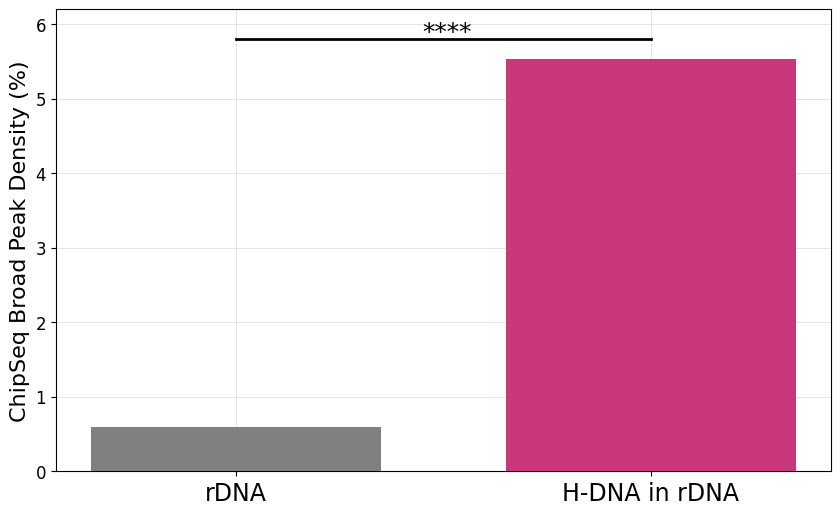

In [472]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.bar(range(2), 
       [chipseq_in_rDNA, chipseq_in_rDNA_with_HDNA], 
       color=['gray', '#c9387a'], 
       width=0.7, 
       zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_ylabel("ChipSeq Broad Peak Density (%)")
ax.yaxis.label.set_size(16)
ax.set_xticks(range(2), ['rDNA', 'H-DNA in rDNA'])
ax.tick_params(axis="x", labelsize=17)
ax.tick_params(axis="y", labelsize=12)
ax.plot(ax.get_xticks(), [5.8, 5.8], color='black', lw=2.0)
mid = (ax.get_xticks()[0] + ax.get_yticks()[1]) / 2
ax.annotate(
            '****', 
            xy=(mid, 5.8), 
            xytext=(mid -0.05, 5.8), 
            fontsize=18
           )

ax.set_ylim(ymax=6.2)
fig.savefig("hdna_rdna_chipseq_broad_density.png", bbox_inches='tight')

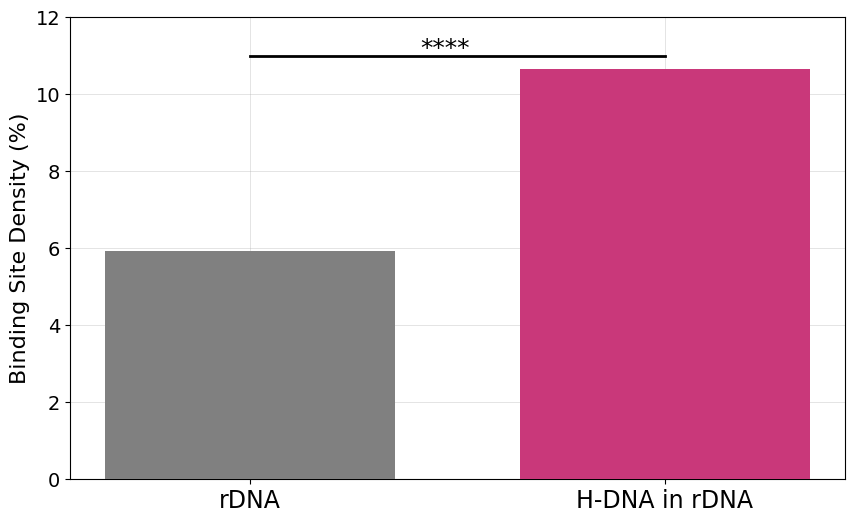

In [471]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.bar(range(2), [prmd9_motif_in_rDNA, prmd9_motif_in_rDNA_with_HDNA], color=['gray', '#c9387a'], width=0.7, zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_ylabel("Binding Site Density (%)")
ax.yaxis.label.set_size(16)
ax.set_xticks(range(2), ['rDNA', 'H-DNA in rDNA'])
ax.tick_params(axis="x", labelsize=17)
ax.tick_params(axis="y", labelsize=14)
ax.plot(ax.get_xticks(), [11.0, 11.0], color='black', lw=2.0)
mid = (ax.get_xticks()[0] + ax.get_yticks()[1]) / 2
ax.annotate(
            '****', 
            xy=(mid, 11.0), 
            xytext=(mid -0.59, 11.0), 
            fontsize=18
           )
ax.set_ylim(ymax=12.0)
fig.savefig("hdna_rdna_recombination_density.png", bbox_inches='tight')

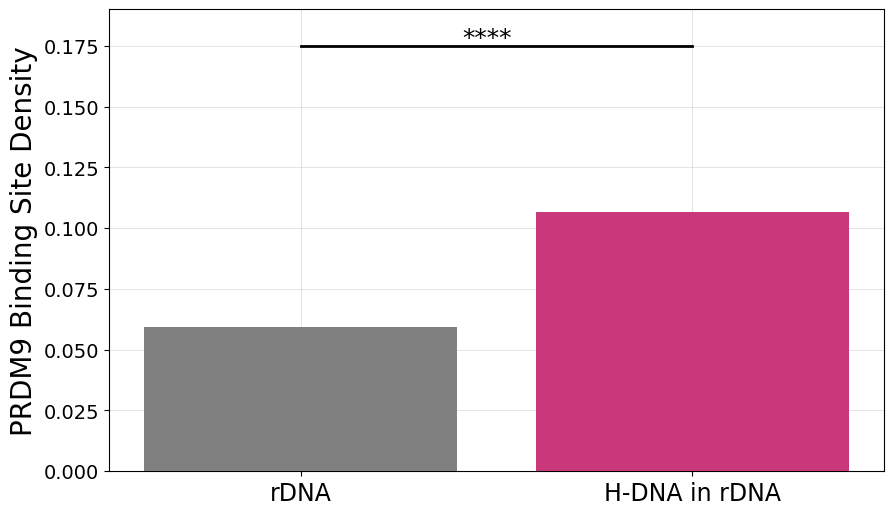

In [444]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.bar(range(2), [c/a, d/c], color=['gray', '#c9387a'], width=0.8, zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_ylabel("PRDM9 Binding Site Density")
ax.yaxis.label.set_size(20)
ax.set_xticks(range(2), ['rDNA', 'H-DNA in rDNA'])
ax.tick_params(axis="x", labelsize=17)
ax.tick_params(axis="y", labelsize=14)
ax.plot(ax.get_xticks(), [0.18, 0.18], color='black', lw=2.0)
mid = (ax.get_xticks()[0] + ax.get_yticks()[1]) / 2
ax.annotate(
            '****', 
            xy=(mid, 0.18), 
            xytext=(mid + 0.4, 0.18), 
            fontsize=18
           )

ax.set_ylim(ymax=0.19)
fig.savefig("hdna_rdna_recombination_density.png", bbox_inches='tight')

In [93]:
(c / a) / ( d / c )

0.2793734675356882

### Density

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


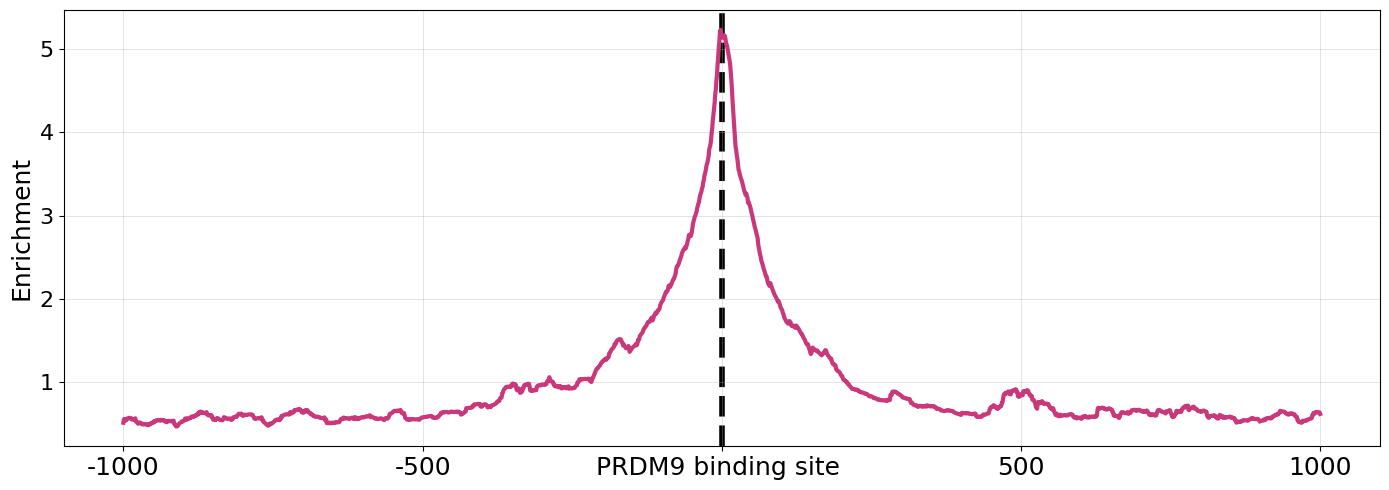

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))
max_alpha = 1.0

ax.plot(range(2*window+1), sites, lw=3.0, zorder=3, color='#c9387a')
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("")
ax.tick_params(which="major", labelsize=16,)
ax.tick_params(axis="x", which="major", labelsize=18)
ax.set_xticks(range(0, window*2+window//2, window//2), [f'{j-window}' if j != window else 'PRDM9 binding site ' for j in range(0, window*2 + window//2, window//2)])

ax.set_ylabel("")
ax.set_ylabel("Enrichment")
ax.yaxis.label.set_size(18)
ax.legend(frameon=True)
plt.tight_layout()
ax.legend(frameon=False, handles=[])
ax.axvline(window, linestyle='--', lw=4.0, color='black', zorder=1)
fig.savefig('density_MID_recombination_HDNA.png', bbox_inches='tight')

plt.show()
plt.close()